In [590]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as funct
import gymnasium as gym
import numpy as np
from collections import namedtuple
from matplotlib import pyplot as plt
import numpy as np
import scipy.optimize as opt

In [591]:
env = gym.make("CartPole-v1")

In [592]:
class NN(nn.Module):
    """A Feed Forward Neural Network used for Deep-Q-Learning to solve the cartpole problem."""
    def __init__(self, obs_dim, n_actions):
        super(NN, self).__init__()      
        # The input (an observation/a state) has shape (4,) [cart pos, cart vel, pole angle, pole angular vel]
        self.fc1 = nn.Linear(*obs_dim, 128) # * to convert tuple (4,) to 4
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions) # n_actions == 2

        self.optimizer = optim.Adam(self.parameters(), lr=1e-4)
        self.loss = nn.MSELoss() #TODO: Possibly replace with nn.HuberLoss or SmoothL1Loss
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, x):
        x = funct.relu(self.fc1(x))
        x = funct.relu(self.fc2(x))
        return self.fc3(x)

In [593]:
class ReplayBuffer(object):
    """A buffer in which the last <mem_size> trajectories are saved for later reuse.
    For training the DQN [train()], trajectories are sampled from it randomly.
    """
    def __init__(self, mem_size, obs_dim):
        # The maximum number of trajectories that are being kept track of at once.
        self.mem_size = mem_size
        # Tracking the number of additions made to the buffer.
        self.save_cntr = 0
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)
        self.state_memory = np.zeros((self.mem_size, *obs_dim),dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *obs_dim), dtype=np.float32)

    def save(self, state, action, reward, state_, is_terminal):
        index = self.save_cntr % self.mem_size

        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.new_state_memory[index] = state_
        self.terminal_memory[index] = is_terminal

        self.save_cntr += 1

    def sample(self, batch_size):
        max_mem = min(self.save_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminals = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminals


In [594]:
class Agent():
    def __init__(self, obs_dim, n_actions, discount, eps, eps_dec, eps_end, batch_size):
        self.obs_dim = obs_dim
        self.n_actions = n_actions
        self.action_space = [i for i in range(n_actions)]
        self.discount = discount
        self.eps = eps
        self.eps_dec = eps_dec
        self.eps_min = eps_end
        self.batch_size = batch_size
        self.net = NN(obs_dim=self.obs_dim, n_actions=self.n_actions)
        self.buf = ReplayBuffer(mem_size=1000, obs_dim=self.obs_dim)

    def pick_action(self, state):
        if np.random.random() > self.eps:
            # Exploitation, meaning we use the model to choose what action (left or right) to take next
            #state = torch.tensor(state, dtype=torch.float, device=self.net.device)#.unsqueeze(0)
            actions = self.net.forward(state) # TODO: this instead of self.net(state) ?
            action =  torch.argmax(actions).item()
        else:
            # Exploration, meaning we sample uniformly from the action space (left, right)
            #action = torch.tensor([[env.action_space.sample()]], device=self.net.device, dtype=torch.long)
            action = np.random.choice(self.action_space)

        # decrease epsilon after every step up to eps_min
        self.eps -= self.eps_dec if self.eps > self.eps_min else 0

        return action
        
    def train(self):
        if self.buf.save_cntr < self.batch_size: return 
        self.net.optimizer.zero_grad()

        batch_index = np.arange(self.batch_size, dtype=np.int32)
        s, a, r, s_, t = self.buf.sample(self.batch_size)

        state_batch = torch.tensor(s).to(self.net.device)
        action_batch = a
        next_state_batch = torch.tensor(s_).to(self.net.device)
        reward_batch = torch.tensor(r).to(self.net.device)
        is_terminal_batch = torch.tensor(t).to(self.net.device)

        q_now = self.net.forward(state_batch)[batch_index, action_batch]
        q_next = self.net.forward(next_state_batch)
        q_next[is_terminal_batch] = 0.0

        q_target = reward_batch + self.discount*torch.max(q_next, dim=1)[0]

        loss = self.net.loss(q_target, q_now).to(self.net.device)
        loss.backward()
        self.net.optimizer.step()

In [595]:
def plot(scores):
    plt.plot(scores)
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.show()

In [596]:
def execute(n_episodes, print_freq = 100):
    agent = Agent(obs_dim=env.observation_space.shape,
                  n_actions=env.action_space.n,
                  discount=0.99,
                  eps=0.99, eps_dec=1e-4, eps_end=0.05, # TODO: Try decreasing eps_end
                  batch_size=10)
    episodes = n_episodes
    # The i-th entry is the accumulated score of episode i
    scores = []
    for i in range(episodes+1):
        score = 0
        terminated = False
        truncated = False
        # This obs is the observation of the initial state
        obs, _ = env.reset()
        obs = torch.tensor(obs, dtype=torch.float, device=agent.net.device)

        while not terminated and not truncated:
            action = agent.pick_action(obs)
            obs_, reward, terminated, truncated, _ = env.step(action)
            # Save this transition into the the agent's ReplayBuffer
            agent.buf.save(obs, action, reward, obs_, terminated or truncated)
            score += reward
            # Train the model using batch
            agent.train()
            # Moving to the next state: s_t := s_t+1
            obs_ = torch.tensor(obs_, dtype=torch.float, device=agent.net.device)
            obs = obs_
        # the episode ended; the accumulated rewards are saved
        scores.append(score)

        if i % print_freq == 0:
            # The mean of the last <print_freq> scores
            avg_score = np.mean(scores[-print_freq:])
            max_score = max(scores[-print_freq:])
            print(f"Episode: {i} -- Average score: {avg_score} -- Highest of last {print_freq}: {max_score}")
    plot(scores)

Episode: 0 -- Average score: 14.0 -- Highest of last 50: 14.0
Episode: 50 -- Average score: 21.86 -- Highest of last 50: 76.0
Episode: 100 -- Average score: 22.34 -- Highest of last 50: 68.0
Episode: 150 -- Average score: 22.3 -- Highest of last 50: 73.0
Episode: 200 -- Average score: 27.58 -- Highest of last 50: 92.0
Episode: 250 -- Average score: 33.38 -- Highest of last 50: 106.0
Episode: 300 -- Average score: 37.12 -- Highest of last 50: 114.0
Episode: 350 -- Average score: 63.82 -- Highest of last 50: 123.0
Episode: 400 -- Average score: 88.26 -- Highest of last 50: 150.0
Episode: 450 -- Average score: 123.64 -- Highest of last 50: 253.0
Episode: 500 -- Average score: 196.26 -- Highest of last 50: 500.0
Episode: 550 -- Average score: 227.86 -- Highest of last 50: 500.0
Episode: 600 -- Average score: 171.94 -- Highest of last 50: 301.0


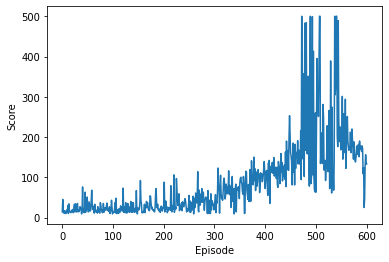

In [597]:
execute(n_episodes=600, print_freq=50)